<a href="https://colab.research.google.com/github/willjhliang/traffic-sign-recognition/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Download dataset from github repo
!git clone --quiet https://github.com/willjhliang/traffic-sign-recognition.git
!mv traffic-sign-recognition/* .
!rm -r traffic-sign-recognition

In [1]:
from copy import deepcopy
import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (4, 2.5)

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

import torch
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils import data
import torchvision

from constants import K, S, class_size, validation_ratio, random_seed
from data import load_data, consolidate_data, split_validation, visualize_data, compare_class_dist
from augment import augment_dataset, visualize_augmentation
from dimensionality_reduction import run_pca, visualize_pca, visualize_pca_per_channel, visualize_image_components
from torch_utils import load_torch_data, train_model, evaluate_model
from evaluation import generate_confusion_matrix, get_classification_report, generate_class_comparison
from explanability import visualize_top_activations, visualize_tsne_similarity, adversarial_attack

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Dataset

In [2]:
train_data = load_data('data/filtered_images/train')
test_data = load_data('data/filtered_images/test')
labels = pd.read_csv("data/filtered_labels.csv")

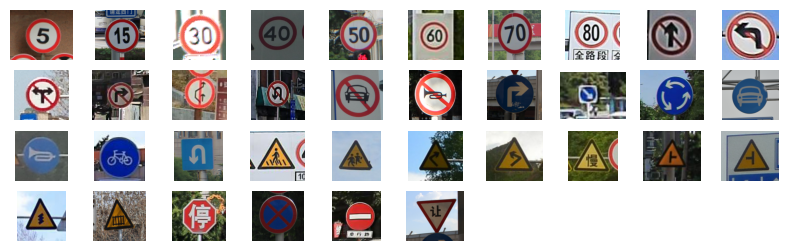

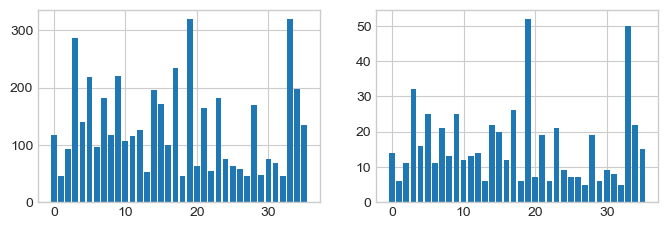

In [3]:
visualize_data(train_data)
compare_class_dist(train_data, test_data)

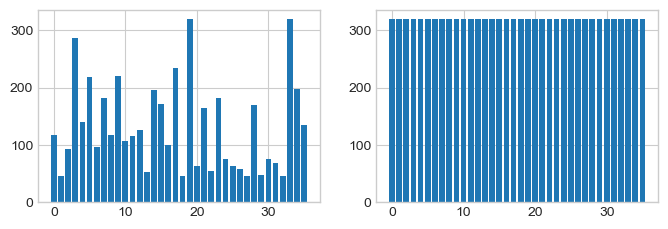

In [4]:
original_train_data = deepcopy(train_data)
train_data = augment_dataset(train_data)
compare_class_dist(original_train_data, train_data)

In [7]:
X_train, X_train_flattened, y_train = consolidate_data(train_data)
X_test, X_test_flattened, y_test = consolidate_data(test_data)

print(f'X_train shape: {X_train.shape}')
print(f'X_train_flattened shape: {X_train_flattened.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (11520, 3, 32, 32)
X_train_flattened shape: (11520, 3072)
X_test shape: (572, 3, 32, 32)


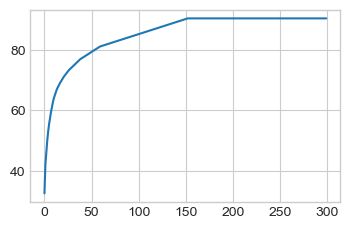

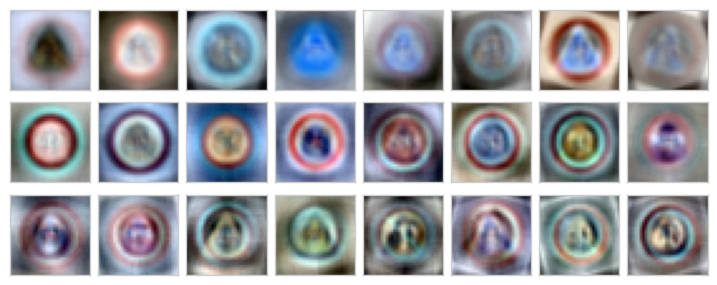

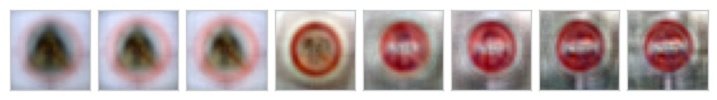

In [8]:
X_train_pca, X_test_pca, pca = run_pca(X_train_flattened, X_test_flattened)
visualize_pca(pca)
visualize_image_components(pca, X_train_flattened[1])

# Models

## Logistic Regression

In [7]:
def logistic_regression(X_train_full, y_train_full, X_test, y_test):
    X_train, X_val, y_train, y_val = split_validation(X_train_full, y_train_full)

    C_values = [0.01, 0.1, 1, 10, 100]
    best_C = -1
    best_acc = 0

    accs = []
    for c in C_values:
        model = LogisticRegression(
            penalty='l2',
            C=c,
            multi_class = 'multinomial',
            max_iter=1000
        )
        model.fit(X_train, y_train)
        acc = model.score(X_val, y_val)
        accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_C = c

    plt.plot(accs)
    plt.xticks(list(range(len(accs))), [str(c) for c in C_values])
    plt.show()
    print(f'Optimal C: {best_C}')

    model = LogisticRegression(
        penalty='l2',
        C=best_C,
        multi_class = 'multinomial',
        max_iter=1000
    )
    model.fit(X_train_full, y_train_full)

    return model.predict(X_test)

## K-Nearest Neighbors

In [20]:
kf = KFold(n_splits=5)


def evaluate_kfold(model_base, X_train, y_train):
    """Evaluates the given model with K-Fold cross validation."""
    total_acc = 0
    for train_index, val_index in kf.split(X_train): # Iterate through folds
       # Split data into training data and validation data
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
 
        # Train model
        model = clone(model_base)
        model.fit(X_train_fold, y_train_fold)
        total_acc += model.score(X_val_fold, y_val_fold)
       
    avg_acc = total_acc / 5
    return avg_acc


def knn(X_train, y_train, X_test, y_test):
    k_values = [1, 3, 5, 7, 9, 11, 13, 15]
    best_k = -1
    best_acc = 0

    accs = []
    for k_neighbors in k_values:
        avg_acc = evaluate_kfold(KNeighborsClassifier(n_neighbors = k_neighbors), X_train, y_train)
        accs.append(avg_acc)
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_k = k_neighbors
 
    plt.plot(k_values, accs)
    plt.show()
    print(f"Optimal k: {best_k}")
    
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, y_train)

    return model.predict(X_test)

## XGBoost

In [10]:
def xgboost(X_train_full, y_train_full, X_test, y_test):
    X_train, X_val, y_train, y_val = split_validation(X_train_full, y_train_full)

    learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    best_lr = -1
    best_acc = 0
 
    accs = []
    for lr in learning_rates:
        model = xgb.XGBClassifier(n_estimators=200, max_depth=1, learning_rate=0.1, objective='multi:softmax', booster='gbtree')
        model.fit(X_train, y_train)
        acc = model.score(X_val, y_val)
        accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
     
    plt.plot(accs)
    plt.xticks(list(range(len(accs))), [str(lr) for lr in learning_rates])
    plt.show()
    print(f'Optimal learning rate: {best_lr}')
  
    model = xgb.XGBClassifier(n_estimators=200, max_depth=1, learning_rate=lr, objective='multi:softmax', booster='gbtree')
    model.fit(X_train_full, y_train_full)

    return model.predict(X_test)


## Kernelized SVM

In [11]:
def kernel_svm(X_train_full, y_train_full, X_test, y_test):
    X_train, X_val, y_train, y_val = split_validation(X_train_full, y_train_full)

    kernels = ['linear', 'poly', 'rbf']
    C_values = [0.01, 0.1, 1, 10, 100]
    best_kernel = ''
    best_C = -1
    best_acc = 0

    accs = {}
    for kernel in kernels:
        accs[kernel] = []
    for kernel, c in itertools.product(kernels, C_values):
        model = SVC(kernel=kernel, C=c)
        model.fit(X_train, y_train)
        acc = model.score(X_val, y_val)
        accs[kernel].append(acc)
        if acc > best_acc:
            best_acc = acc
            best_C = c
            best_kernel = kernel
    
    best_accs = [max(accs[kernel]) for kernel in kernels]
    plt.bar(kernels, best_accs)
    plt.xticks(list(range(len(best_accs))), kernels)
    plt.show()
    print(f'Optimal kernel: {best_kernel}')

    model = SVC(kernel=best_kernel, C=best_C)
    model.fit(X_train_full, y_train_full)

    return model.predict(X_test)

## Dense Neural Network

In [12]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 128)
        self.layer2 = nn.Linear(128, 64)
        self.out_layer = nn.Linear(64, K)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.out_layer(x)
        return x

## Convolutional Neural Network

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)
        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.dropout_3 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)
        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)
        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_3(x)
        x = self.linear_2(x)
        return x

# Transfer Learning

In [14]:
def Resnet():
    model = torchvision.models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, K)
    return model

In [15]:
def VGG16():
    model = torchvision.models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, K)
    return model

In [16]:
def EfficientNet():
    model = torchvision.models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, K)
    return model

In [17]:
class UpscaleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
        img = self.transform(torch.from_numpy(self.X[idx].astype(np.float32)))
        label = torch.tensor(self.y[idx])

        return img, label


def load_vit_data(X_train, y_train, X_test, y_test):
    X_train, X_val, y_train, y_val = split_validation(X_train, y_train)
    transform = torchvision.transforms.Resize((224, 224))
    train_set = UpscaleDataset(X_train, y_train, transform)
    val_set = UpscaleDataset(X_val, y_val, transform)
    test_set = UpscaleDataset(X_test, y_test, transform)
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=32, shuffle=True)
    return train_loader, val_loader, test_loader


def VisionTransformer():
    model = torchvision.models.vit_b_16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.heads[-1].in_features
    model.heads[-1] = nn.Linear(num_ftrs, K)
    return model

# Training and Evaluation
We now run all the models defined above.

In [ ]:
print('========== Logistic Regression ==========')
y_pred_log = logistic_regression(X_train_flattened, y_train, X_test_flattened, y_test)

In [ ]:
log_report, log_df = get_classification_report(y_test, y_pred_log, labels)
generate_class_comparison(log_report, 'f1-score', labels)

In [ ]:
print('========== Logistic Regression (PCA) ==========')
y_pred_log = logistic_regression(X_train_pca, y_train, X_test_pca, y_test)

In [ ]:
log_report, log_df = get_classification_report(y_test, y_pred_log, labels)
generate_class_comparison(log_report, 'f1-score', labels)

In [ ]:
print('========== KNN ==========')
y_pred_knn = knn(X_train_flattened, y_train, X_test_flattened, y_test)

In [ ]:
knn_reportdict, knn_df = get_classification_report(y_test, y_pred_knn, labels)
generate_class_comparison(knn_reportdict, 'f1-score', labels)

========== KNN (PCA) ==========


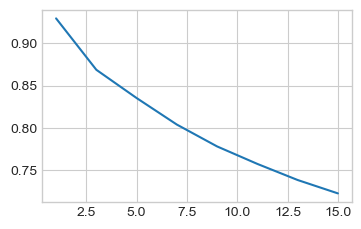

Optimal k: 1


In [21]:
print('========== KNN (PCA) ==========')
y_pred_knnpca = knn(X_train_pca, y_train, X_test_pca, y_test)

accuracy: 0.9737762237762237
┌──────────────┬─────────────┬──────────┬────────────┬───────────┐
│              │   precision │   recall │   f1-score │   support │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │    0.965564 │ 0.970079 │   0.965473 │       572 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.976825 │ 0.973776 │   0.973884 │       572 │
└──────────────┴─────────────┴──────────┴────────────┴───────────┘


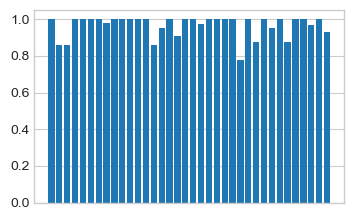

In [22]:
knnpca_reportdict, knnpca_df = get_classification_report(y_test, y_pred_knnpca, labels)
generate_class_comparison(knnpca_reportdict, 'f1-score', labels)

In [ ]:
print('========== XGBoost (PCA) ==========')
y_pred_xgb = xgboost(X_train_pca, y_train, X_test_pca, y_test)

In [ ]:
xgb_reportdict, xbg_df = get_classification_report(y_test, y_pred_xgb, labels)
generate_class_comparison(xgb_reportdict, 'f1-score', labels)

In [ ]:
print('========== Kernelized SVM ==========')
y_pred_svm = kernel_svm(X_train_flattened, y_train, X_test_flattened, y_test)

In [ ]:
svm_reportdict, svm_df = get_classification_report(y_test, y_pred_svm, labels)
generate_class_comparison(svm_reportdict, 'f1-score', labels)

In [ ]:
print('========== Kernelized SVM (PCA) ==========')
y_pred_svm = kernel_svm(X_train_pca, y_train, X_test_pca, y_test)

In [ ]:
svm_reportdict, svm_df = get_classification_report(y_test, y_pred_svm, labels)
generate_class_comparison(svm_reportdict, 'f1-score', labels)

In [ ]:
print('========== Dense Neural Network ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train_flattened, y_train, X_test_flattened, y_test)
model = train_model(NN(), train_loader, val_loader, 10, 1e-3)
(y_pred_nn, y_label_nn), _ = evaluate_model(model, test_loader)

In [ ]:
nn_reportdict, nn_df = get_classification_report(y_label_nn, y_pred_nn, labels)
generate_class_comparison(nn_reportdict, 'f1-score', labels)

In [ ]:
print('========== Convolutional Neural Network ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)

In [ ]:
visualize_top_activations(model, X_train)

In [ ]:
visualize_tsne_similarity(model, X_train)

In [ ]:
adversarial_attack(model, labels)

In [ ]:
print('========== Transfer Learning Resnet ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(Resnet(), train_loader, val_loader, 10, 1e-3)
(y_pred_res, y_label_res), _ = evaluate_model(model, test_loader)

In [ ]:
res_reportdict, res_df = get_classification_report(y_label_res, y_pred_res, labels)
generate_class_comparison(res_reportdict, 'f1-score', labels)

In [ ]:
print('========== Transfer Learning VGG16 ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(VGG16(), train_loader, val_loader, 10, 1e-3)
(y_pred_vgg, y_label_vgg), _ = evaluate_model(model, test_loader)

In [ ]:
vgg_reportdict, vgg_df = get_classification_report(y_label_vgg, y_pred_vgg, labels)
generate_class_comparison(vgg_reportdict, 'f1-score', labels)

In [ ]:
print('========== Transfer Learning EfficientNet ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(EfficientNet(), train_loader, val_loader, 10, 1e-3)
(y_pred_eff, y_label_eff), _ = evaluate_model(model, test_loader)

In [ ]:
eff_reportdict, eff_df = get_classification_report(y_label_eff, y_pred_eff, labels)
generate_class_comparison(eff_reportdict, 'f1-score', labels)